In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from xgboost import XGBClassifier

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission_data = pd.read_csv("sample_submission.csv")

print("train_data : ", train_data.shape)
print("test_data : ", test_data.shape)
print("sample_submission_data : ", sample_submission_data.shape)

train_data :  (3116945, 22)
test_data :  (2077964, 21)
sample_submission_data :  (2077964, 2)


In [3]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [5]:
train_data = train_data.drop_duplicates()
train_data.shape

(3116945, 22)

In [6]:
# % missing values
def null_percent(df):
    null_count = df.isnull().sum()
    total_rows = len(df)
    percent_missing = (null_count/total_rows) * 100
    rounded_percent = percent_missing.round(2)
    return rounded_percent

print("Train Data NaN Values")
print(null_percent(train_data))
print("Test Data NaN Values")
print(null_percent(test_data))

Train Data NaN Values
id                       0.00
class                    0.00
cap-diameter             0.00
cap-shape                0.00
cap-surface             21.53
cap-color                0.00
does-bruise-or-bleed     0.00
gill-attachment         16.81
gill-spacing            40.37
gill-color               0.00
stem-height              0.00
stem-width               0.00
stem-root               88.45
stem-surface            63.55
stem-color               0.00
veil-type               94.88
veil-color              87.94
has-ring                 0.00
ring-type                4.13
spore-print-color       91.43
habitat                  0.00
season                   0.00
dtype: float64
Test Data NaN Values
id                       0.00
cap-diameter             0.00
cap-shape                0.00
cap-surface             21.51
cap-color                0.00
does-bruise-or-bleed     0.00
gill-attachment         16.83
gill-spacing            40.40
gill-color               0.00
stem-height 

In [7]:
def fill_na_with_median(df):
    num_cols = df.select_dtypes(include=['float64']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

fill_na_with_median(train_data)
fill_na_with_median(test_data)

Distribution of 'class':
class
p    1705396
e    1411549
Name: count, dtype: int64


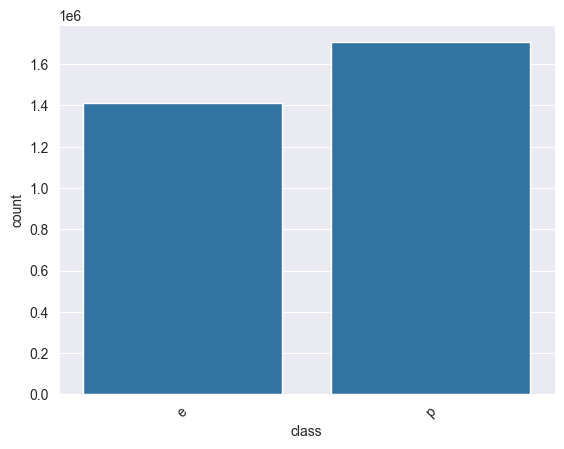

In [8]:
def plot_class_distribution(df, column_name):
    # the number of appearances for each class
    class_counts = df[column_name].value_counts()
    print(f"Distribution of '{column_name}':\n{class_counts}\n")

    # graph
    sns.countplot(x=column_name,data=df)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_data,'class')

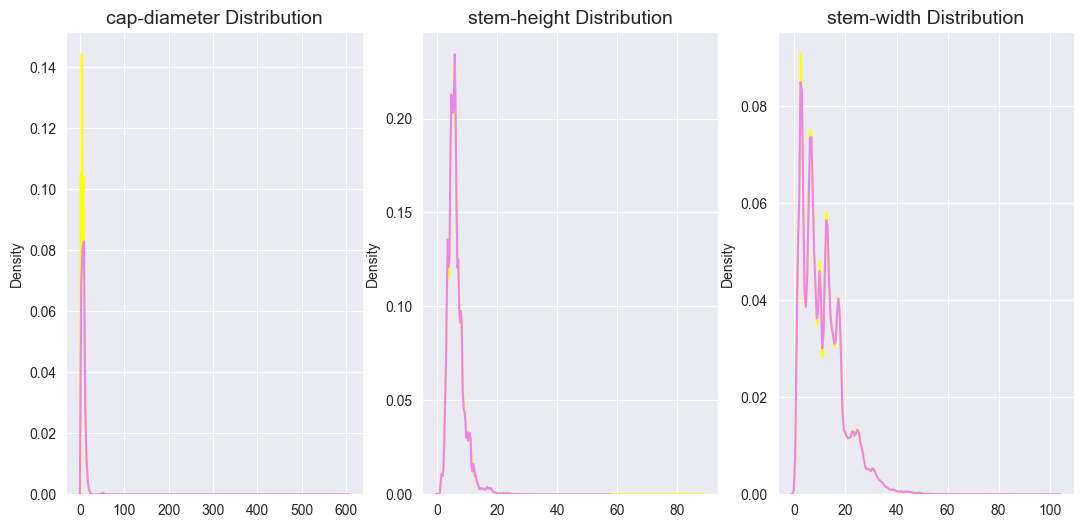

In [11]:
num_cols= train_data._get_numeric_data().columns.difference(['id']) # does not include id 

fig, axes = plt.subplots(1,3, figsize=(13,6))

for index, column in enumerate(num_cols):
    if column in train_data.columns:
        sns.kdeplot(data=train_data, x=column, ax=axes[index], label='Train',color='yellow')
    if column in test_data.columns:
        sns.kdeplot(data=test_data,x=column, ax=axes[index], label='Test',color='violet')

    axes[index].set_title(f'{column} Distribution', fontsize = 14)
    axes[index].set_xlabel(None)

In [12]:
num_cols= train_data._get_numeric_data().columns.difference(['id']) # does not include id 
cat_cols = list(train_data.select_dtypes(include=['object']).columns.difference(['class'])) #does not include class

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

train_data = train_data.fillna('missing')
test_data = test_data.fillna('missing')

In [15]:
# conv categorical data -> numerical data
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_data[cat_cols] = encoder.fit_transform(train_data[cat_cols])
test_data[cat_cols] = encoder.transform(test_data[cat_cols])

In [17]:
labelencoder = LabelEncoder()
train_data['class'] = labelencoder.fit_transform(train_data['class'])

In [18]:
# Compute the correlation matrix
correlation_matrix = train_data.corr()

# Get the correlation of all features with the target variable
target_correlation = correlation_matrix['class'].sort_values(ascending=False)

print(target_correlation)

class                   1.000000
ring-type               0.104391
stem-root               0.089160
veil-type               0.050546
has-ring                0.049627
cap-color               0.042242
gill-spacing            0.017896
id                     -0.000136
spore-print-color      -0.018026
habitat                -0.027666
cap-surface            -0.036086
does-bruise-or-bleed   -0.037556
stem-surface           -0.039736
stem-height            -0.049740
gill-attachment        -0.051355
gill-color             -0.057018
veil-color             -0.058906
season                 -0.063554
stem-color             -0.068543
cap-shape              -0.089083
cap-diameter           -0.162626
stem-width             -0.169807
Name: class, dtype: float64


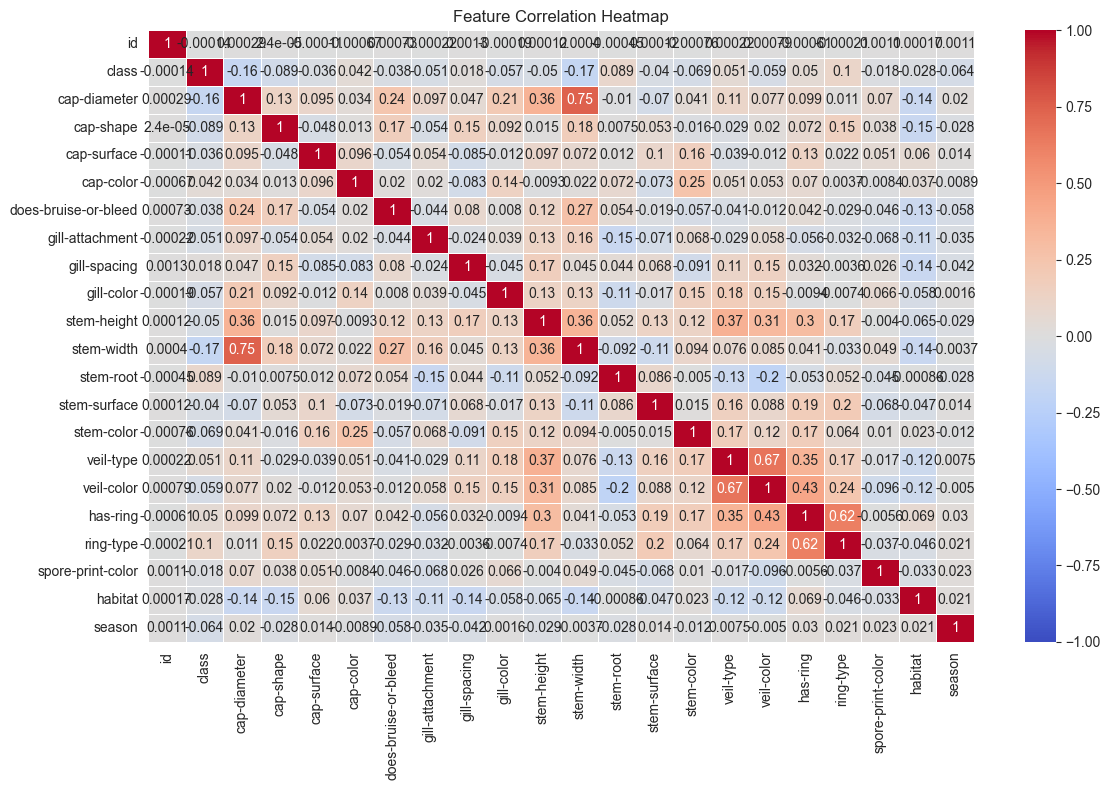

In [19]:
correlation_matrix = train_data.corr()

# matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [23]:
X = train_data.drop(['class'], axis=1)
y = train_data['class']
test = test_data.drop(['id'], axis=1)
X.shape,test.shape

((3116945, 21), (2077964, 20))

In [25]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

params_input = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'random_state': 42
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier(**params_input)
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

test_preds = model.predict(test_data)  

predictions = labelencoder.inverse_transform(test_preds)

submission = pd.DataFrame({'id': test_data.id, 'class': predictions})

submission.to_csv('submission.csv', index=False)

class_distribution = submission['class'].value_counts()
print(f"Class Distribution in Submission:\n{class_distribution}")



Matthews Correlation Coefficient: 0.9510153278447105
Confusion Matrix:
[[277086   5224]
 [  9965 331114]]
Class Distribution in Submission:
class
1    1119860
0     958104
Name: count, dtype: int64
